<a href="https://colab.research.google.com/github/TheRoberto2512/DeepBrainMRI/blob/main/Modello_Convolutivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**SOMMARIO DEL NOTEBOOK**</font>

In questo notebook viene costruito un modello Convolutivo sfruttando tutte le best practices per le reti convolutive: connessioni residue, normalizzazione batch e convoluzioni separabili. Per maggiori informazioni riguardo le scelte intraprese fare riferimento al report finale.


**Indice:**
*   [Installazioni, import librerie e funzioni utili](#1)
*   [Caricamento del Dataset](#2)
*   [Modello Convolutivo](#3)
*   [Risultati dell'addestramento](#4)
*   [Modello Finale](#5)



<a name="1"></a>
# Installazioni, import librerie e funzioni utili

In [ ]:
! pip install tensorflow-gpu==2.8.3

In [ ]:
from sklearn.metrics import confusion_matrix                                      # per la matrice di confusione
from google.colab import drive, files
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd                                                               # per gestire la serializzazione/deserializzazione dei risultati
import numpy as np
import shutil                                                                     # per fare spostamenti e copie tra drive e colab
import os                                                                         # per gestire le cartelle dei dataset

In [ ]:
drive.mount("/content/drive", force_remount=True)                                 # montiamo il drive per prelevare i dataset

Qualora la cartella principale del progetto non si trovi nella home di Google Drive, personalizzare la seguente stringa:

In [ ]:
#@title Qualora la cartella principale del progetto non si trovi nella home di Google Drive, personalizzare la seguente stringa:

main_folder_path = '/content/drive/MyDrive/DeepBrainMRI' #@param {type:"string"}

Le seguenti funzioni servono per salvare/caricare facilmente le history, le evaluation e i pesi del modello su Google Drive.

In [ ]:
result_folder_path = f"{main_folder_path}/Risultati vari/Convolutivo"
saved_weights_path = f"{main_folder_path}/Saved Weights/Convolutivo"
dataset_directory = ''

def saveHistory(history, nomeFile):                                               # funzione per salvare la history di un addestramento
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  history_df = pd.DataFrame.from_dict(history.history)
  history_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_history.csv", index=False)

def loadHistory(nomeFile):                                                        # funzione per caricare la history di un addestramento
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_history.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveEvaluation(loss, acc, f1, nomeFile):                                      # funzione per salvare il risultato di un evaluation
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  evaluation = {}
  evaluation['loss'] = loss
  evaluation['accuracy'] = acc
  evaluation['f1_score'] = f1
  evaluation_df = pd.DataFrame.from_dict(evaluation)
  evaluation_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_evaluation.csv", index=False)

def loadEvaluation(nomeFile):                                                     # funzione per caricare il risultato di un evaluation
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_evaluation.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveWeights(nomeFile):                                                        # funzione per salvare il file dei pesi su drive
  if not os.path.exists(saved_weights_path):
    os.makedirs(saved_weights_path)
  shutil.copy(nomeFile, f"{saved_weights_path}")

def loadWeights(nomeFile):                                                        # funzione per caricare il file dei pesi da drive
  if os.path.exists(saved_weights_path):
    shutil.copy(f"{saved_weights_path}/{nomeFile}", '/content/')
  else:
    raise Exception("Cartella inesistente!")

<a name="2"></a>
# Caricamento del Dataset


Impostiamo dei valori costanti per la corretta esecuzione del notebook.

In [ ]:
#@title Impostiamo dei valori costanti per la corretta esecuzione del notebook.
base_datasets_path = f"{main_folder_path}/Datasets/"

BATCH_SIZE = 32 #@param {type: "integer"}                       # specifichiamo la grandezza dei batch
IMAGE_WIDTH = 299 #@param {type: "integer"}
IMAGE_HEIGHT = 299 #@param {type: "integer"}

IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)                    # c'è solamente un canale perché importiamo in scala di grigi

SEED = 2680 #@param {type: "integer"}                           # seme per poter replicare le stesse condizioni del dataset

Scegliere il tipo di dataset (train_data) che si vuole importare:

In [ ]:
dataset_directory = 'under+aug'                                 # dataset con undersampling e data augmentation

In [ ]:
dataset_directory = 'only_under'                                # dataset con SOLO undersampling

In [ ]:
dataset_directory = 'only_aug'                                  # dataset con solo data augmentation

In [ ]:
dataset_directory = 'base'                                      # dataset base (non pre-processato)

Istruzioni per importare il dataset. **Sono richiesti fino a 2-3 minuti a seconda del dataset!**

In [ ]:
destinazione = f"/content/dataset/{dataset_directory}"

if dataset_directory != 'base':
  shutil.copytree(f'{base_datasets_path}{dataset_directory}', f'{destinazione}/Training', dirs_exist_ok=True)     # train_data pre-processato
else:
  shutil.copytree(f'{base_datasets_path}DATASET_BASE/Training', f'{destinazione}/Training', dirs_exist_ok=True)   # train_data base
print(f"Ho importato il training set \'{dataset_directory}\' nella cartella {destinazione}/Training")

shutil.copytree(f'{base_datasets_path}DATASET_BASE/Testing', f'{destinazione}/Testing', dirs_exist_ok=True)       # importa il test_data
print(f"Ho importato il test set nella cartella {destinazione}/Testing")

Ho importato il training set 'base' nella cartella /content/dataset/base/Training
Ho importato il test set nella cartella /content/dataset/base/Testing


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Training',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Testing',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

class_names = test_data.class_names
print("\nHo caricato train_data e test_data dalla cartella %s" % destinazione)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.

Ho caricato train_data e test_data dalla cartella /content/dataset/base


Stampando la shape di un batch di immagini possiamo notare che corrisponderà a:

(**BATCH_SIZE**, **IMAGE_WIDTH**, **IMAGE_HEIGHT**, **1**)

In [ ]:
for img, lbl in train_data.take(1):
  print(img.shape)

(32, 299, 299, 1)


<a name="3"></a>
# Modello Convolutivo

In [ ]:
def residual_block(x, filters):
  residual = x
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
  x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same", use_bias=False)(residual)
  x = tf.keras.layers.add([x, residual])
  return x

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for filters in [32, 64, 128, 256, 512]:
  x = residual_block(x, filters)

x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 1)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 295, 295, 32)         800       ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 295, 295, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="Convolutivo.keras", save_best_only=True, monitor="val_loss"),  # salviamo i pesi dell'epoca con la val_loss minore
]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.008,                                                                        # learning rate iniziale
    decay_steps=len(train_data)*5,                                                # ogni quanto si decrementa il learning rate
    decay_rate=0.5,                                                               # tasso di decremento
    staircase=True)                                                               # decrementa a intervalli discreti

In [ ]:
model.compile(loss='kullback_leibler_divergence', optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Compila il modello

In [ ]:
total_batches = tf.data.experimental.cardinality(train_data).numpy()              # calcola il numero totale di batch nel dataset

validation_size = int(0.2 * total_batches)                                        # imposta una percentuale per il validation set (20%)

# separa i dataset di training e validation
validation_data = train_data.take(validation_size)
train_data = train_data.skip(validation_size)

In [ ]:
epochs = 20
history = model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

Epoch 1/20
93/93 [==============================] - 46s 371ms/step - loss: 1.4466 - accuracy: 0.5382 - precision_3: 0.5803 - recall_3: 0.4527 - f1_score: 0.5345 - val_loss: 1.4598 - val_accuracy: 0.2609 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1036
Epoch 2/20
93/93 [==============================] - 36s 356ms/step - loss: 0.8081 - accuracy: 0.6885 - precision_3: 0.7316 - recall_3: 0.6372 - f1_score: 0.6821 - val_loss: 1.6213 - val_accuracy: 0.3723 - val_precision_3: 0.5056 - val_recall_3: 0.1223 - val_f1_score: 0.2658
Epoch 3/20
93/93 [==============================] - 38s 372ms/step - loss: 0.7907 - accuracy: 0.7064 - precision_3: 0.7365 - recall_3: 0.6686 - f1_score: 0.7010 - val_loss: 1.4761 - val_accuracy: 0.4728 - val_precision_3: 0.5034 - val_recall_3: 0.4062 - val_f1_score: 0.3873
Epoch 4/20
93/93 [==============================] - 38s 379ms/step - loss: 0.9235 - accuracy: 0.6726 - precision_3: 0.7032 - recall_3: 0.6355 - f1_score: 0.6671 - val_

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model("Convolutivo.keras")

Se invece si volessero caricare dei pesi da Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio:")
name = input()
loadWeights(name)
model.load_weights(name)

Per valutare le performance del modello:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 =  model.evaluate(test_data)

print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

41/41 [==============================] - 3s 75ms/step - loss: 0.0918 - accuracy: 0.9756 - precision_1: 0.9763 - recall_1: 0.9756 - f1_score: 0.9744
Loss: 0.09181986004114151
Accuracy: 0.9755911231040955
Precision: 0.976335883140564
Recall: 0.9755911231040955
F1-score: 0.9744447469711304


## Salvataggio dei dati

Per salvare i pesi del modello attuale su Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio (deve terminare con .keras):")
name = input()
model.save_weights(name)
saveWeights(name)

Qualora si voglia salvare la history in un file .csv:

In [ ]:
nome = input()
saveHistory(history, nome)

Qualora si voglia salvare l'evaluation in un file .csv:

In [ ]:
nome = input()
saveEvaluation(test_loss, test_accuracy, test_f1, nome)

<a name="4"></a>
# Risultati dell'addestramento

## History dell'addestramento appena concluso

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(history.history['f1_score'][i]))
  val_f1_score.append(np.mean(history.history['val_f1_score'][i]))

## History di un addestramento passato (da caricare)

Per ricaricare una history precedente:

In [ ]:
print("Inserire il nome del file history da caricare:")
nomeFile = input()
history = loadHistory(nomeFile)

In [ ]:
acc, val_acc, loss, val_loss = [], [], [], []
for i in range(0, len(history['accuracy'])):
  acc.append(history['accuracy'][i])
  val_acc.append(history['val_accuracy'][i])
  loss.append(history['loss'][i])
  val_loss.append(history['val_loss'][i])

epochs = range(1, len(acc)+1)

f1_score, val_f1_score = [], []

for i in range(len(acc)):
  f1_score.append(np.mean([float(x) for x in history['f1_score'][i].replace('[', '').replace(']', '').split()]))
  val_f1_score.append(np.mean([float(x) for x in history['val_f1_score'][i].replace('[', '').replace(']', '').split()]))

## Plot dei risultati

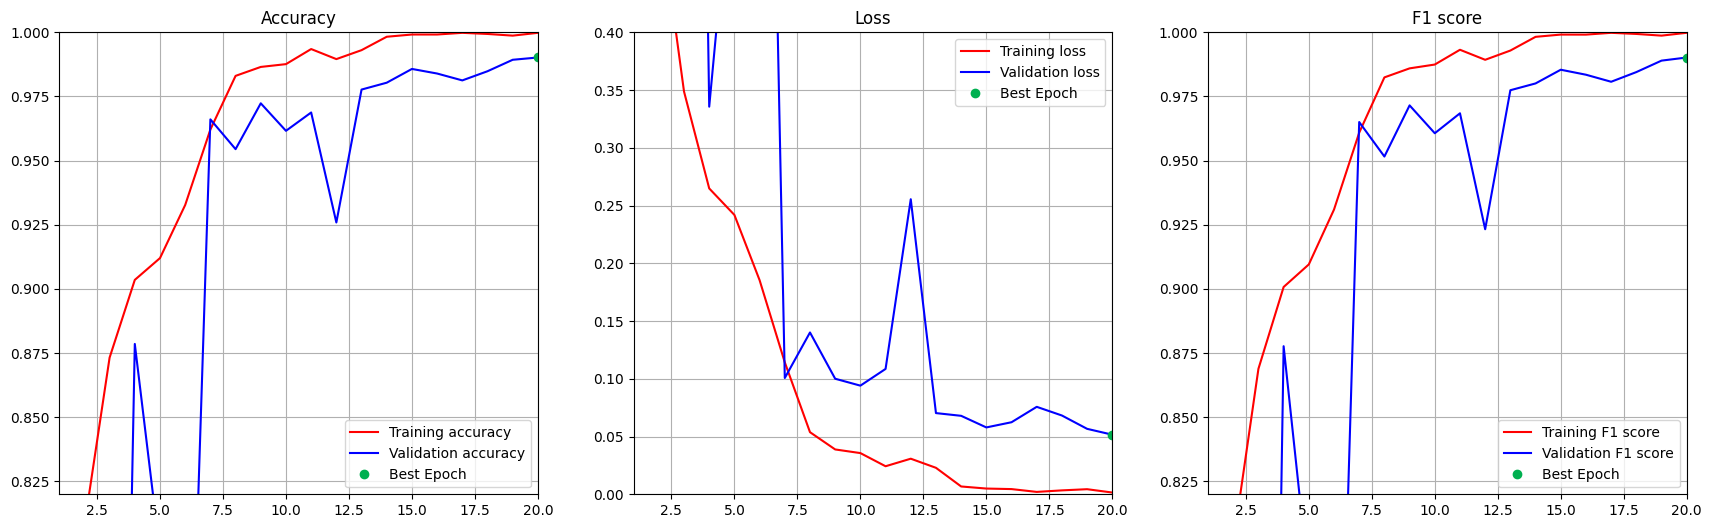

In [ ]:
# Creazione del grafico per l'accuracy
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')

plt.plot(np.argmax((val_acc))+1, np.max(val_acc), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0.82, 1])
plt.grid()

# Creazione del grafico per il loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')

plt.plot(np.argmin((val_loss))+1, np.min(val_loss), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0, 0.4])
plt.grid()

# Creazione del grafico per l'F1 score
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, 'r', label='Training F1 score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 score')
plt.title('F1 score')

plt.plot(np.argmax((val_f1_score))+1, np.max(val_f1_score), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0.82, 1])
plt.grid()

plt.show()

<a name="5"></a>
# Modello finale

Una volta valutate i migliori iperparametri per il nostro modello, lo riaddestriamo interamente sul training set senza nessun validation.
<font color='#c00000'>**ATTENZIONE**:</font> Ricaricare il test data se è stato splittato precedentemente per il validation!

In [ ]:
def residual_block(x, filters):
  residual = x
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
  x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same", use_bias=False)(residual)
  x = tf.keras.layers.add([x, residual])
  return x

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for filters in [32, 64, 128, 256, 512]:
  x = residual_block(x, filters)

x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="Convolutivo_Finale.keras", save_best_only=True, monitor="loss"),  # salviamo i pesi dell'epoca con la loss minore
]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.008,
    decay_steps=len(train_data)*5,
    decay_rate=0.5,
    staircase=True)

In [ ]:
model.compile(loss='kullback_leibler_divergence', optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Compila il modello

In [ ]:
epochs = 20
history = model.fit(train_data, epochs=epochs, callbacks=callbacks)

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model("Convolutivo_Finale.keras")

Se invece si volessero caricare dei pesi da Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio:")
name = input()
loadWeights(name)
model.load_weights(name)

Per valutare le performance del modello:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 =  model.evaluate(test_data)

print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

41/41 [==============================] - 4s 71ms/step - loss: 0.0715 - accuracy: 0.9840 - precision_2: 0.9840 - recall_2: 0.9832 - f1_score: 0.9830
Loss: 0.07145624607801437
Accuracy: 0.9839816689491272
Precision: 0.9839694499969482
Recall: 0.9832189083099365
F1-score: 0.9829752445220947


##Matrice di confusione

Creazione della matrice di confusione:

In [ ]:
previsioni_classe = []
verita_terreno = []

# Effettuare le previsioni su ogni batch
for immagini, etichette in test_data:
    preds = model.predict(immagini, verbose=0)
    previsioni_classe.extend(np.argmax(preds, axis=1))
    verita_terreno.extend(np.argmax(etichette.numpy(), axis=1))

# Calcolare la matrice di confusione
matrice_confusione = confusion_matrix(verita_terreno, previsioni_classe)

Creazione del plot della matrice di confusione:

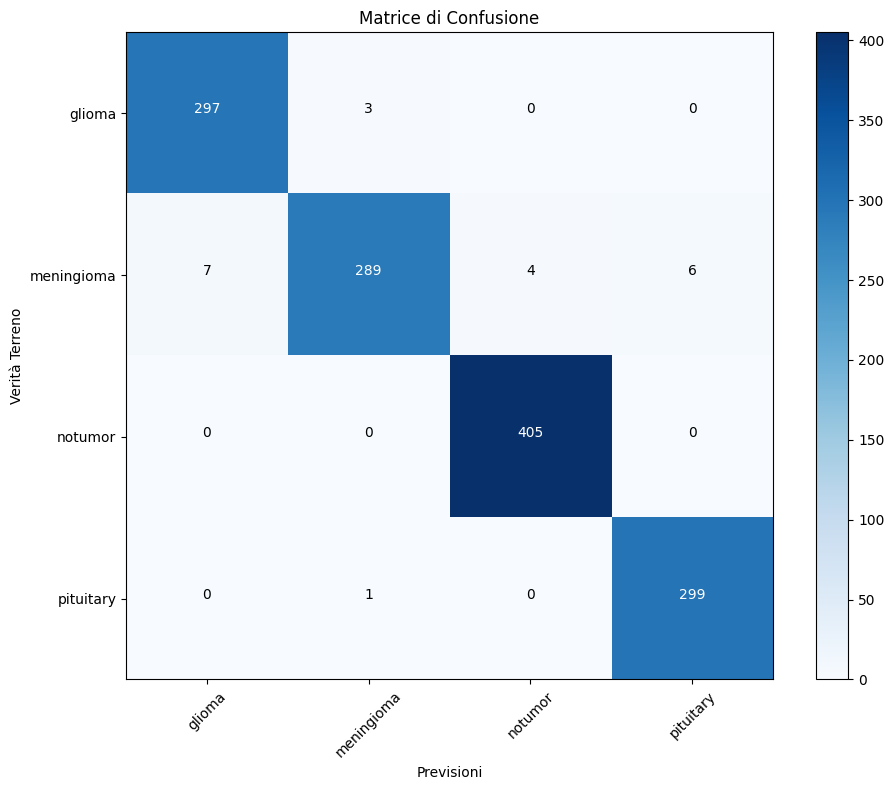

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(matrice_confusione, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.colorbar()

# Aggiungere le etichette agli assi
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Etichettare gli assi
plt.xlabel('Previsioni')
plt.ylabel('Verità Terreno')

# Mostrare i numeri all'interno delle celle
thresh = matrice_confusione.max() / 2.
for i in range(matrice_confusione.shape[0]):
    for j in range(matrice_confusione.shape[1]):
        plt.text(j, i, format(matrice_confusione[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrice_confusione[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Salvataggio dei dati

Per salvare i pesi del modello attuale su Google Drive:

In [ ]:
print("Inserire il nome del file di salvataggio (deve terminare con .keras):")
name = input()
model.save_weights(name)
saveWeights(name)

Qualora si voglia salvare la history in un file .csv:

In [ ]:
nome = input()
saveHistory(history, nome)

Qualora si voglia salvare l'evaluation in un file .csv:

In [ ]:
nome = input()
saveEvaluation(test_loss, test_accuracy, test_f1, nome)